<a href="https://colab.research.google.com/github/danielnzlz01/ULead-Quemaduras/blob/main/EfficientNetB7%2BYOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/qubvel/segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-0cb3e1tj
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-0cb3e1tj
  Resolved https://github.com/qubvel/segmentation_models to commit e951c6747f75fa9e7240816d1c79dd2e66813123
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


In [2]:
import cv2
import numpy as np
from efficientnet.tfkeras import EfficientNetB7
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from collections import Counter
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
images = '/content/drive/Shareddrives/Skin Burn/dataset/images'
labels = '/content/drive/Shareddrives/Skin Burn/dataset/Labels'

In [5]:
# Cargar el modelo EfficientNetB7 preentrenado (sin incluir la capa de clasificación)
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

In [6]:
# Agregar una capa de clasificación personalizada
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)

# Definir la lista de clases
num_classes = 3

predictions = Dense(num_classes, activation='softmax')(x)  # Reemplaza num_classes con el número de clases en tu conjunto de datos

# Enable mixed precision training
#policy = tf.keras.mixed_precision.Policy('mixed_float16')
#tf.keras.mixed_precision.set_global_policy(policy)

# Combinar el modelo base con la capa de clasificación personalizada
model = Model(inputs=base_model.input, outputs=predictions)

In [7]:
# Compilar el modelo
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 150, 150, 64  1728        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 150, 150, 64  256         ['stem_conv[0][0]']              
                                )                                                             

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.286673 to fit



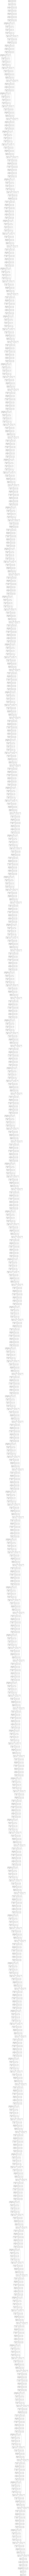

In [9]:
plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
)

In [10]:
# Cargar los datos de entrenamiento
image_dir = images # Ruta al directorio que contiene las imágenes
labels_dir = labels  # Ruta al directorio que contiene los archivos de etiquetas YOLO

train_images = []
train_labels = []

# Procesar las imágenes y etiquetas YOLO
count = 0
for image_file in os.listdir(image_dir):
    if image_file.endswith(".jpg"):
        image_path = os.path.join(image_dir, image_file)
        # Cargar el archivo de etiquetas YOLO correspondiente a la imagen actual
        labels_file = os.path.join(labels_dir, image_file.replace('.jpg', '.txt'))

        if os.path.isfile(labels_file) and os.path.getsize(labels_file) > 0:
          image = cv2.imread(image_path)
          resized_image = cv2.resize(image, (300, 300))
          normalized_image = resized_image / 255.0
          train_images.append(normalized_image)

          with open(labels_file, 'r') as f:
              lines = f.readlines()

          classes = []
          for line in lines:
              label = line.strip().split(' ')
              class_index = int(label[0])
              classes.append(class_index)

          # Seleccionar la clase más común si hay múltiples clases
          if len(classes) > 1:
              class_counts = Counter(classes)
              most_common_class = class_counts.most_common(1)[0][0]
              train_labels.append(most_common_class)
          else:
              train_labels.append(classes[0])

          count += 1
          if count >= 1000:
              break

train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [11]:
# Convertir las etiquetas a one-hot encoding
train_labels_one_hot = to_categorical(train_labels, num_classes)

In [12]:
train_images, test_images, train_labels, test_labels = train_test_split(train_images, train_labels_one_hot, test_size=0.2, random_state=42)

# Further split training set into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [13]:
# Entrenar el modelo
model.fit(x=train_images, y=train_labels, validation_data=(val_images, val_labels), epochs=10, batch_size=8)

Epoch 1/10
80/80 [==============================] - 245s 930ms/step - loss: 1.5235 - categorical_accuracy: 0.4266 - val_loss: 6.2612 - val_categorical_accuracy: 0.4938
Epoch 2/10
80/80 [==============================] - 68s 856ms/step - loss: 1.0552 - categorical_accuracy: 0.4812 - val_loss: 0.9127 - val_categorical_accuracy: 0.5625
Epoch 3/10
80/80 [==============================] - 66s 832ms/step - loss: 0.8527 - categorical_accuracy: 0.6000 - val_loss: 1.2799 - val_categorical_accuracy: 0.5500
Epoch 4/10
80/80 [==============================] - 66s 830ms/step - loss: 0.8071 - categorical_accuracy: 0.6375 - val_loss: 0.8339 - val_categorical_accuracy: 0.6125
Epoch 5/10
80/80 [==============================] - 68s 849ms/step - loss: 0.7520 - categorical_accuracy: 0.6609 - val_loss: 1.2773 - val_categorical_accuracy: 0.5938
Epoch 6/10
80/80 [==============================] - 66s 831ms/step - loss: 0.7557 - categorical_accuracy: 0.6641 - val_loss: 1.1567 - val_categorical_accuracy: 0.51

In [14]:
model.evaluate(test_images, test_labels)

7/7 [==============================] - 12s 587ms/step - loss: 1.1656 - categorical_accuracy: 0.5950


[1.165602207183838, 0.5950000286102295]

In [15]:
model.save_weights(input('Nombre: ')+'.h5', overwrite=True)

Nombre: modelo


In [16]:
# Realizar la predicción en una imagen de prueba
image_path = '/content/drive/Shareddrives/Skin Burn/dataset/images/img1393.jpg'  # Ruta a tu imagen de prueba
image = cv2.imread(image_path)
resized_image = cv2.resize(image, (300, 300))
normalized_image = resized_image / 255.0
input_image = np.expand_dims(normalized_image, axis=0)
predictions = model.predict(input_image)

# Analizar las predicciones
class_indices = np.argmax(predictions, axis=-1)
confidence_scores = np.max(predictions, axis=-1)

# Definir los nombres de clase correspondientes a los índices
class_names = ['Grado 1', 'Grado 2', 'Grado 3']  # Reemplaza con los nombres de clase correctos

for i, class_index in enumerate(class_indices):
    class_name = class_names[class_index]
    confidence = confidence_scores[i]
    print(f'Objeto {i+1}: {class_name} - Confianza: {confidence}')

1/1 [==============================] - 7s 7s/step
Objeto 1: Grado 2 - Confianza: 0.9572446942329407
